In [ ]:
!pip3 install torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
import torch
import torchvision.datasets as dts 
import torchvision.transforms as trnsfrms
import torch.nn as nn
import matplotlib.pyplot as plot
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pickle

DATA_PATH = "/content/drive/My Drive"
infile = open(DATA_PATH+'/train_data.pkl','rb')
best_model2 = pickle.load(infile)

import pandas as pd

var=pd.read_pickle('/content/drive/My Drive/train_data.pkl')
Y = var['y']
X = var['X']
print(X.size)

from sklearn import preprocessing

from sklearn.model_selection import train_test_split
StandDev = np.std(X,axis = 0,keepdims = True)
Mean= np.mean(X,axis = 0,keepdims=True)
Normalized_X = (X-Mean)/(StandDev + 1e-7)

testsize = 0.5
X_train, X_test, y_train, y_test = train_test_split(Normalized_X, Y, test_size = testsize,random_state = 42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
47040000
(30000, 784)


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(30000, 784) (30000, 1)
(30000, 784) (30000, 1)


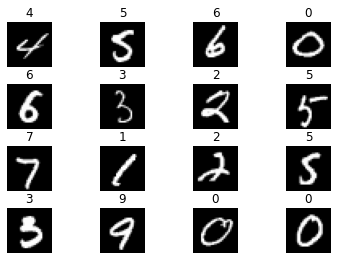

In [ ]:
import matplotlib.pyplot as plt
import random
for i in range(16):
    plt.subplot(4,4,i+1)
    index=random.randrange(0,60000)
    image = X[index]
    image = np.array(image, dtype='float')
    pixels = image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.title(Y[index][0])
    plt.axis('off')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class MNIST_Dataset(Dataset):
  def __init__(self, x, y):
    self.images = x
    self.labels = y

  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, idx):
    return self.images[idx], self.labels[idx]

In [ ]:
from torch.utils.data import DataLoader

train_dataset = MNIST_Dataset(X_train, y_train)
test_dataset = MNIST_Dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size =64, shuffle = True)

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.linear1 = nn.Linear(28*28, 100) 
    self.linear2 = nn.Linear(100, 100) 
    self.final = nn.Linear(100, 10)
    self.relu = nn.ReLU()

  def forward(self, img): #convert + flatten
    x = img.view(-1, 28*28)
    x = self.relu(self.linear1(x))
    x = self.relu(self.linear2(x))
    x = self.final(x)
    return x

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()

In [ ]:
print(device)

cpu


In [ ]:
model = Net().to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

Net(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (final): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
)


In [ ]:
def train(model, criterion, optimizer, train_dataloader, epochs):
  for epoch in range(epochs):
    running_loss = 0
    for data in train_dataloader:
      inputs, labels = data[0].to(device), data[1].to(device)
      optimizer.zero_grad()
      outputs = model(inputs.float())
      labels = torch.flatten(labels)
      loss = criterion(outputs, labels.type(torch.LongTensor))
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
    
    print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss/len(train_dataloader)))
  
  print("training complete")

In [ ]:
train(model,criterion,optimizer,train_dataloader,20)

[Epoch 1] loss: 1.078
[Epoch 2] loss: 0.315
[Epoch 3] loss: 0.234
[Epoch 4] loss: 0.196
[Epoch 5] loss: 0.170
[Epoch 6] loss: 0.149
[Epoch 7] loss: 0.132
[Epoch 8] loss: 0.119
[Epoch 9] loss: 0.106
[Epoch 10] loss: 0.096
[Epoch 11] loss: 0.087
[Epoch 12] loss: 0.078
[Epoch 13] loss: 0.071
[Epoch 14] loss: 0.064
[Epoch 15] loss: 0.058
[Epoch 16] loss: 0.052
[Epoch 17] loss: 0.047
[Epoch 18] loss: 0.043
[Epoch 19] loss: 0.038
[Epoch 20] loss: 0.034
training complete


In [ ]:
def test(model, test_dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_dataloader:
      inputs, labels = data[0].to(device), data[1].to(device)
      labels = torch.flatten(labels).type(torch.LongTensor)
      outputs = model(inputs.float())
      _, predicted = torch.max(outputs.data,1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      #model.eval()
  
  print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))

In [ ]:
test(model, test_dataloader)

Accuracy of the network on test images: 96.337 %
